##### Copyright 2019 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# pix2pix: 条件付き GAN による画像から画像への変換

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/generative/pix2pix"><img src="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/pix2pix.ipynb">TensorFlow.orgで表示</a></td>
  <td> <img src="https://www.tensorflow.org/images/colab_logo_32px.png"><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/generative/pix2pix.ipynb">Google Colab で実行</a> </td>
  <td> <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png"><a target="_blank" href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/pix2pix.ipynb">GitHub でソースを表示</a> </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/generative/pix2pix.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
</table>

このチュートリアルでは、Isola et al による『[Image-to-image translation with conditional adversarial networks](https://arxiv.org/abs/1611.07004)』（2017 年）で説明されているように、入力画像から出力画像へのマッピングを学習する pix2pix と呼ばれる条件付き敵対的生成ネットワーク（cGAN）を構築し、トレーニングする方法を説明します。pix2pix はアプリケーションに依存しません。ラベルマップからの写真の合成、モノクロ画像からのカラー写真の生成、Google Maps の写真から航空写真への変換、スケッチ画像から写真への変換など、広範なタスクに適用できます。

この例のネットワークは、[プラハにあるチェコ工科大学](http://cmp.felk.cvut.cz/~tylecr1/facade/){:.external} の[機械知覚センター](http://cmp.felk.cvut.cz/){:.external} が提供する [CMP Facade Database](https://www.cvut.cz/) を使用して、建築物のファサード（正面部）の画像を生成します。この例を手短に紹介できるように、pix2pix の著者が作成したデータセットの[事前処理済みのセット](https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external}を使用します。

pix2pix の cGAN では、入力画像で条件付けを行い、対応する出力画像を生成します。cGANs は『[Conditional Generative Adversarial Nets](https://arxiv.org/abs/1411.1784)』（2014 年 Mirza and Osindero）おいて初めて言及されました。

ネットワークのアーキテクチャには、以下の項目が含まれます。

- [U-Net](https://arxiv.org/abs/1505.04597){:.external}  ベースのアーキテクチャを使用したジェネレータ。
- 畳みこみ PatchGAN 分類器で表現されたディスクリミネータ（[pix2pix 論文](https://arxiv.org/abs/1611.07004){:.external} で提案）。

単一の V100 GPU で、エポックごとに約 15 秒かかる可能性があります。

以下は、ファサードデータセットを使って 200 エポックトレーニング（8 万ステップ）した後に pix2pix xGAN が生成した出力の例です。

![出力例 1](https://www.tensorflow.org/images/gan/pix2pix_1.png) ![出力例 2](https://www.tensorflow.org/images/gan/pix2pix_2.png)

## TensorFlow とその他のライブラリをインポートする

In [2]:
import tensorflow as tf

import os
import pathlib
import time
import datetime

from matplotlib import pyplot as plt
from IPython import display

2024-01-11 23:04:41.772344: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 23:04:41.772392: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 23:04:41.774012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## データセットを読み込む

CMP Facade データベースのデータをダウンロードします（30 MB）。追加のデータセットは[こちら](http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/){:.external} から同じ形式で入手できます。Colab では、ドロップダウンメニューから別のデータセットを選択できます。他のデータベースの一部は非常に大きいことに注意してください（`edges2handbags` は 8 GB）。 

In [3]:
dataset_name = "facades" #@param ["cityscapes", "edges2handbags", "edges2shoes", "facades", "maps", "night2day"]


In [4]:
_URL = f'http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/{dataset_name}.tar.gz'

path_to_zip = tf.keras.utils.get_file(
    fname=f"{dataset_name}.tar.gz",
    origin=_URL,
    extract=True)

path_to_zip  = pathlib.Path(path_to_zip)

PATH = path_to_zip.parent/dataset_name

    8192/30168306 [..............................] - ETA: 0s

   16384/30168306 [..............................] - ETA: 1:33

   49152/30168306 [..............................] - ETA: 1:04

   90112/30168306 [..............................] - ETA: 52s 

  131072/30168306 [..............................] - ETA: 50s

  229376/30168306 [..............................] - ETA: 1:22

  385024/30168306 [..............................] - ETA: 53s 

  475136/30168306 [..............................] - ETA: 1:05

  483328/30168306 [..............................] - ETA: 1:10

  499712/30168306 [..............................] - ETA: 1:29

  655360/30168306 [..............................] - ETA: 1:09

  671744/30168306 [..............................] - ETA: 1:10

  696320/30168306 [..............................] - ETA: 1:10

  720896/30168306 [..............................] - ETA: 1:09

  737280/30168306 [..............................] - ETA: 1:10

  761856/30168306 [..............................] - ETA: 1:09

  786432/30168306 [..............................] - ETA: 1:09

  819200/30168306 [..............................] - ETA: 1:08

  843776/30168306 [..............................] - ETA: 1:08

  868352/30168306 [..............................] - ETA: 1:08

  901120/30168306 [..............................] - ETA: 1:07

  925696/30168306 [..............................] - ETA: 1:06

  958464/30168306 [..............................] - ETA: 1:06

  991232/30168306 [..............................] - ETA: 1:05

 1024000/30168306 [>.............................] - ETA: 1:04

 1056768/30168306 [>.............................] - ETA: 1:04

 1089536/30168306 [>.............................] - ETA: 1:03

 1122304/30168306 [>.............................] - ETA: 1:03

 1163264/30168306 [>.............................] - ETA: 1:02

 1204224/30168306 [>.............................] - ETA: 1:01

 1245184/30168306 [>.............................] - ETA: 1:00

 1286144/30168306 [>.............................] - ETA: 59s 

 1335296/30168306 [>.............................] - ETA: 58s

 1376256/30168306 [>.............................] - ETA: 57s

 1425408/30168306 [>.............................] - ETA: 56s

 1466368/30168306 [>.............................] - ETA: 55s

 1515520/30168306 [>.............................] - ETA: 55s

 1564672/30168306 [>.............................] - ETA: 54s

 1622016/30168306 [>.............................] - ETA: 53s

 1679360/30168306 [>.............................] - ETA: 52s

 1736704/30168306 [>.............................] - ETA: 51s

 1794048/30168306 [>.............................] - ETA: 50s

 1851392/30168306 [>.............................] - ETA: 49s

 1908736/30168306 [>.............................] - ETA: 48s

 1974272/30168306 [>.............................] - ETA: 47s

 2056192/30168306 [=>............................] - ETA: 46s

 2121728/30168306 [=>............................] - ETA: 45s

 2195456/30168306 [=>............................] - ETA: 44s

 2269184/30168306 [=>............................] - ETA: 43s

 2342912/30168306 [=>............................] - ETA: 42s

 2424832/30168306 [=>............................] - ETA: 41s

 2498560/30168306 [=>............................] - ETA: 40s

 2580480/30168306 [=>............................] - ETA: 39s

 2662400/30168306 [=>............................] - ETA: 39s

 2752512/30168306 [=>............................] - ETA: 38s

 2842624/30168306 [=>............................] - ETA: 37s

 2932736/30168306 [=>............................] - ETA: 36s

 3031040/30168306 [==>...........................] - ETA: 35s

 3129344/30168306 [==>...........................] - ETA: 34s

 3235840/30168306 [==>...........................] - ETA: 34s

 3334144/30168306 [==>...........................] - ETA: 33s

 3440640/30168306 [==>...........................] - ETA: 32s

 3555328/30168306 [==>...........................] - ETA: 31s

 3670016/30168306 [==>...........................] - ETA: 31s

 3784704/30168306 [==>...........................] - ETA: 30s

 3907584/30168306 [==>...........................] - ETA: 29s

 4022272/30168306 [==>...........................] - ETA: 28s

 4153344/30168306 [===>..........................] - ETA: 28s

 4276224/30168306 [===>..........................] - ETA: 27s

 4415488/30168306 [===>..........................] - ETA: 26s

 4546560/30168306 [===>..........................] - ETA: 26s

 4685824/30168306 [===>..........................] - ETA: 25s

 4825088/30168306 [===>..........................] - ETA: 25s

 4972544/30168306 [===>..........................] - ETA: 24s

 5120000/30168306 [====>.........................] - ETA: 23s

 5267456/30168306 [====>.........................] - ETA: 23s

 5423104/30168306 [====>.........................] - ETA: 22s

 5586944/30168306 [====>.........................] - ETA: 22s

 5750784/30168306 [====>.........................] - ETA: 21s

 5914624/30168306 [====>.........................] - ETA: 21s

 6086656/30168306 [=====>........................] - ETA: 20s

 6283264/30168306 [=====>........................] - ETA: 19s

 6447104/30168306 [=====>........................] - ETA: 19s

 6594560/30168306 [=====>........................] - ETA: 19s

 6782976/30168306 [=====>........................] - ETA: 18s

 6979584/30168306 [=====>........................] - ETA: 18s

 7176192/30168306 [======>.......................] - ETA: 17s

 7380992/30168306 [======>.......................] - ETA: 17s

 7593984/30168306 [======>.......................] - ETA: 16s

 7806976/30168306 [======>.......................] - ETA: 16s

 8019968/30168306 [======>.......................] - ETA: 15s

 8241152/30168306 [=======>......................] - ETA: 15s

 8470528/30168306 [=======>......................] - ETA: 15s

 8699904/30168306 [=======>......................] - ETA: 14s

 8937472/30168306 [=======>......................] - ETA: 14s

 9183232/30168306 [========>.....................] - ETA: 13s

 9420800/30168306 [========>.....................] - ETA: 13s

 9674752/30168306 [========>.....................] - ETA: 13s

 9928704/30168306 [========>.....................] - ETA: 12s

10190848/30168306 [=========>....................] - ETA: 12s

10469376/30168306 [=========>....................] - ETA: 11s

10739712/30168306 [=========>....................] - ETA: 11s

10969088/30168306 [=========>....................] - ETA: 11s

11173888/30168306 [==========>...................] - ETA: 11s

11460608/30168306 [==========>...................] - ETA: 10s

11755520/30168306 [==========>...................] - ETA: 10s

12058624/30168306 [==========>...................] - ETA: 10s

12214272/30168306 [===========>..................] - ETA: 10s

12304384/30168306 [===========>..................] - ETA: 10s

12320768/30168306 [===========>..................] - ETA: 11s

12484608/30168306 [===========>..................] - ETA: 11s

12500992/30168306 [===========>..................] - ETA: 11s

12509184/30168306 [===========>..................] - ETA: 11s

12525568/30168306 [===========>..................] - ETA: 11s

12541952/30168306 [===========>..................] - ETA: 11s

12558336/30168306 [===========>..................] - ETA: 11s

12582912/30168306 [===========>..................] - ETA: 11s

12599296/30168306 [===========>..................] - ETA: 11s

12615680/30168306 [===========>..................] - ETA: 11s

12640256/30168306 [===========>..................] - ETA: 11s

12664832/30168306 [===========>..................] - ETA: 11s

12681216/30168306 [===========>..................] - ETA: 11s

12705792/30168306 [===========>..................] - ETA: 11s

12730368/30168306 [===========>..................] - ETA: 11s

12754944/30168306 [===========>..................] - ETA: 11s

12787712/30168306 [===========>..................] - ETA: 11s

12812288/30168306 [===========>..................] - ETA: 11s

12836864/30168306 [===========>..................] - ETA: 11s

12869632/30168306 [===========>..................] - ETA: 11s

12902400/30168306 [===========>..................] - ETA: 11s

12935168/30168306 [===========>..................] - ETA: 11s

12967936/30168306 [===========>..................] - ETA: 11s

13008896/30168306 [===========>..................] - ETA: 11s

13049856/30168306 [===========>..................] - ETA: 11s

13082624/30168306 [============>.................] - ETA: 11s

13123584/30168306 [============>.................] - ETA: 11s

13164544/30168306 [============>.................] - ETA: 11s

13205504/30168306 [============>.................] - ETA: 11s

13246464/30168306 [============>.................] - ETA: 11s

13287424/30168306 [============>.................] - ETA: 11s

13336576/30168306 [============>.................] - ETA: 11s

13385728/30168306 [============>.................] - ETA: 11s

13434880/30168306 [============>.................] - ETA: 11s

13484032/30168306 [============>.................] - ETA: 11s

13533184/30168306 [============>.................] - ETA: 11s

13590528/30168306 [============>.................] - ETA: 11s

13639680/30168306 [============>.................] - ETA: 11s

13705216/30168306 [============>.................] - ETA: 11s

13770752/30168306 [============>.................] - ETA: 11s

13828096/30168306 [============>.................] - ETA: 11s

13885440/30168306 [============>.................] - ETA: 11s

13950976/30168306 [============>.................] - ETA: 11s

14016512/30168306 [============>.................] - ETA: 11s

14082048/30168306 [=============>................] - ETA: 11s

14155776/30168306 [=============>................] - ETA: 11s

14221312/30168306 [=============>................] - ETA: 11s

14295040/30168306 [=============>................] - ETA: 11s

14376960/30168306 [=============>................] - ETA: 11s

14450688/30168306 [=============>................] - ETA: 11s

14532608/30168306 [=============>................] - ETA: 11s

14614528/30168306 [=============>................] - ETA: 11s

14704640/30168306 [=============>................] - ETA: 11s

14786560/30168306 [=============>................] - ETA: 11s

14876672/30168306 [=============>................] - ETA: 10s

14958592/30168306 [=============>................] - ETA: 10s

14991360/30168306 [=============>................] - ETA: 10s

15089664/30168306 [==============>...............] - ETA: 10s

15187968/30168306 [==============>...............] - ETA: 10s

15294464/30168306 [==============>...............] - ETA: 10s

15392768/30168306 [==============>...............] - ETA: 10s

15499264/30168306 [==============>...............] - ETA: 10s

15613952/30168306 [==============>...............] - ETA: 10s

15736832/30168306 [==============>...............] - ETA: 10s

15851520/30168306 [==============>...............] - ETA: 10s

15966208/30168306 [==============>...............] - ETA: 9s 

16089088/30168306 [==============>...............] - ETA: 9s

16211968/30168306 [===============>..............] - ETA: 9s

16343040/30168306 [===============>..............] - ETA: 9s

16465920/30168306 [===============>..............] - ETA: 9s

16605184/30168306 [===============>..............] - ETA: 9s

16744448/30168306 [===============>..............] - ETA: 9s

16883712/30168306 [===============>..............] - ETA: 9s

17031168/30168306 [===============>..............] - ETA: 8s

17195008/30168306 [================>.............] - ETA: 8s

17342464/30168306 [================>.............] - ETA: 8s

17506304/30168306 [================>.............] - ETA: 8s

17678336/30168306 [================>.............] - ETA: 8s

17833984/30168306 [================>.............] - ETA: 8s

18006016/30168306 [================>.............] - ETA: 8s

18178048/30168306 [=================>............] - ETA: 7s

18333696/30168306 [=================>............] - ETA: 7s

18513920/30168306 [=================>............] - ETA: 7s

18702336/30168306 [=================>............] - ETA: 7s

18898944/30168306 [=================>............] - ETA: 7s

19095552/30168306 [=================>............] - ETA: 7s

19300352/30168306 [==================>...........] - ETA: 6s

19505152/30168306 [==================>...........] - ETA: 6s

19718144/30168306 [==================>...........] - ETA: 6s

19931136/30168306 [==================>...........] - ETA: 6s

20111360/30168306 [==================>...........] - ETA: 6s

20267008/30168306 [===================>..........] - ETA: 6s

20496384/30168306 [===================>..........] - ETA: 5s

20660224/30168306 [===================>..........] - ETA: 5s

20897792/30168306 [===================>..........] - ETA: 5s

21143552/30168306 [====================>.........] - ETA: 5s

21389312/30168306 [====================>.........] - ETA: 5s

21635072/30168306 [====================>.........] - ETA: 5s

21897216/30168306 [====================>.........] - ETA: 4s

22167552/30168306 [=====================>........] - ETA: 4s

22437888/30168306 [=====================>........] - ETA: 4s

22634496/30168306 [=====================>........] - ETA: 4s

22921216/30168306 [=====================>........] - ETA: 4s

23166976/30168306 [======================>.......] - ETA: 4s

23379968/30168306 [======================>.......] - ETA: 3s

23683072/30168306 [======================>.......] - ETA: 3s

23986176/30168306 [======================>.......] - ETA: 3s

24305664/30168306 [=======================>......] - ETA: 3s

24625152/30168306 [=======================>......] - ETA: 3s

24895488/30168306 [=======================>......] - ETA: 2s

25182208/30168306 [========================>.....] - ETA: 2s

25427968/30168306 [========================>.....] - ETA: 2s

25518080/30168306 [========================>.....] - ETA: 2s

25616384/30168306 [========================>.....] - ETA: 2s

25706496/30168306 [========================>.....] - ETA: 2s

25812992/30168306 [========================>.....] - ETA: 2s

25960448/30168306 [========================>.....] - ETA: 2s

26099712/30168306 [========================>.....] - ETA: 2s

26198016/30168306 [=========================>....] - ETA: 2s

26288128/30168306 [=========================>....] - ETA: 2s

26378240/30168306 [=========================>....] - ETA: 2s

26468352/30168306 [=========================>....] - ETA: 2s

26476544/30168306 [=========================>....] - ETA: 2s

26574848/30168306 [=========================>....] - ETA: 2s

26591232/30168306 [=========================>....] - ETA: 2s

26607616/30168306 [=========================>....] - ETA: 2s

26624000/30168306 [=========================>....] - ETA: 2s

26648576/30168306 [=========================>....] - ETA: 2s

26673152/30168306 [=========================>....] - ETA: 2s

26705920/30168306 [=========================>....] - ETA: 2s

26722304/30168306 [=========================>....] - ETA: 2s

26738688/30168306 [=========================>....] - ETA: 2s

26755072/30168306 [=========================>....] - ETA: 2s

26771456/30168306 [=========================>....] - ETA: 2s

26804224/30168306 [=========================>....] - ETA: 2s

26845184/30168306 [=========================>....] - ETA: 2s

26869760/30168306 [=========================>....] - ETA: 2s

26894336/30168306 [=========================>....] - ETA: 1s

26927104/30168306 [=========================>....] - ETA: 1s

26959872/30168306 [=========================>....] - ETA: 1s

26992640/30168306 [=========================>....] - ETA: 1s

27033600/30168306 [=========================>....] - ETA: 1s

27066368/30168306 [=========================>....] - ETA: 1s

27107328/30168306 [=========================>....] - ETA: 1s

27148288/30168306 [=========================>....] - ETA: 1s

27189248/30168306 [==========================>...] - ETA: 1s

27238400/30168306 [==========================>...] - ETA: 1s

27287552/30168306 [==========================>...] - ETA: 1s

27336704/30168306 [==========================>...] - ETA: 1s

27394048/30168306 [==========================>...] - ETA: 1s

27443200/30168306 [==========================>...] - ETA: 1s

27500544/30168306 [==========================>...] - ETA: 1s

27557888/30168306 [==========================>...] - ETA: 1s

27615232/30168306 [==========================>...] - ETA: 1s

27672576/30168306 [==========================>...] - ETA: 1s

27729920/30168306 [==========================>...] - ETA: 1s

27787264/30168306 [==========================>...] - ETA: 1s

27852800/30168306 [==========================>...] - ETA: 1s

27918336/30168306 [==========================>...] - ETA: 1s

27983872/30168306 [==========================>...] - ETA: 1s

28057600/30168306 [==========================>...] - ETA: 1s

28123136/30168306 [==========================>...] - ETA: 1s

28196864/30168306 [===========================>..] - ETA: 1s

28278784/30168306 [===========================>..] - ETA: 1s

28352512/30168306 [===========================>..] - ETA: 1s

28434432/30168306 [===========================>..] - ETA: 1s

28516352/30168306 [===========================>..] - ETA: 1s

28606464/30168306 [===========================>..] - ETA: 0s

28704768/30168306 [===========================>..] - ETA: 0s

28803072/30168306 [===========================>..] - ETA: 0s

28901376/30168306 [===========================>..] - ETA: 0s

28999680/30168306 [===========================>..] - ETA: 0s

29097984/30168306 [===========================>..] - ETA: 0s

29196288/30168306 [============================>.] - ETA: 0s

29310976/30168306 [============================>.] - ETA: 0s

29425664/30168306 [============================>.] - ETA: 0s

29540352/30168306 [============================>.] - ETA: 0s

29646848/30168306 [============================>.] - ETA: 0s

29769728/30168306 [============================>.] - ETA: 0s

29892608/30168306 [============================>.] - ETA: 0s

30023680/30168306 [============================>.] - ETA: 0s

30162944/30168306 [============================>.] - ETA: 0s

30168306/30168306 [==============================] - 19s 1us/step


In [5]:
list(PATH.parent.iterdir())

[PosixPath('/home/kbuilder/.keras/datasets/shakespeare.txt'),
 PosixPath('/home/kbuilder/.keras/datasets/jena_climate_2009_2016.csv.zip'),
 PosixPath('/home/kbuilder/.keras/datasets/cats_and_dogs_filtered'),
 PosixPath('/home/kbuilder/.keras/datasets/Giant Panda'),
 PosixPath('/home/kbuilder/.keras/datasets/spa-eng'),
 PosixPath('/home/kbuilder/.keras/datasets/194px-New_East_River_Bridge_from_Brooklyn_det.4a09796u.jpg'),
 PosixPath('/home/kbuilder/.keras/datasets/cifar-10-batches-py'),
 PosixPath('/home/kbuilder/.keras/datasets/ImageNetLabels.txt'),
 PosixPath('/home/kbuilder/.keras/datasets/320px-Felis_catus-cat_on_snow.jpg'),
 PosixPath('/home/kbuilder/.keras/datasets/iris_training.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/flower_photos.tgz'),
 PosixPath('/home/kbuilder/.keras/datasets/Fireboat'),
 PosixPath('/home/kbuilder/.keras/datasets/iris_test.csv'),
 PosixPath('/home/kbuilder/.keras/datasets/Red_sunflower'),
 PosixPath('/home/kbuilder/.keras/datasets/surf.jpg'),
 Posix

それぞれの元の画像のサイズは `256 x 512` で、`256 x 256` の画像が 2 つ含まれます。

In [6]:
sample_image = tf.io.read_file(str(PATH / 'train/1.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 512, 3)


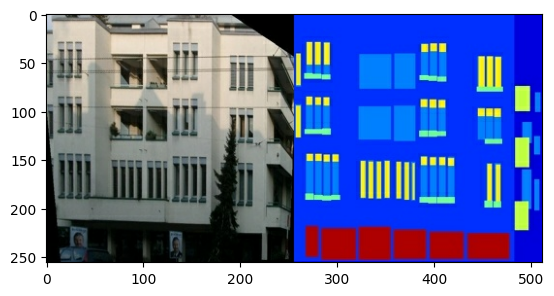

In [7]:
plt.figure()
plt.imshow(sample_image)

実際の建物のファサードの写真と建築ラベル画像を分離する必要があります。すべてのサイズは `256 x 256` になります。

画像ファイルを読み込んで 2 つの画像テンソルを出力する関数を定義します。

In [8]:
def load(image_file):
  # Read and decode an image file to a uint8 tensor
  image = tf.io.read_file(image_file)
  image = tf.io.decode_jpeg(image)

  # Split each image tensor into two tensors:
  # - one with a real building facade image
  # - one with an architecture label image 
  w = tf.shape(image)[1]
  w = w // 2
  input_image = image[:, w:, :]
  real_image = image[:, :w, :]

  # Convert both images to float32 tensors
  input_image = tf.cast(input_image, tf.float32)
  real_image = tf.cast(real_image, tf.float32)

  return input_image, real_image

入力（建築ラベル画像）画像と実際の（建物のファサードの写真）画像のサンプルをプロットします。

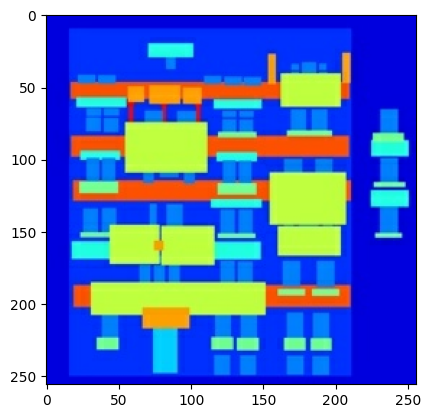

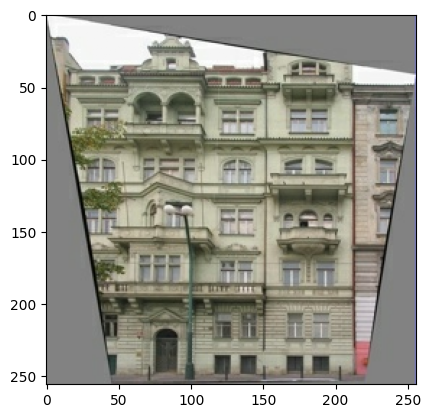

In [9]:
inp, re = load(str(PATH / 'train/100.jpg'))
# Casting to int for matplotlib to display the images
plt.figure()
plt.imshow(inp / 255.0)
plt.figure()
plt.imshow(re / 255.0)

[pix2pix 論文](https://arxiv.org/abs/1611.07004){:.external} に述べられているように、トレーニングセットを前処理するために、ランダムなジッターとミラーリングを適用する必要があります。

以下を行う関数を定義します。

1. `256 x 256` の画像サイズをそれぞれより大きな高さと幅の `286 x 286` に変更する。
2. それをランダムに `256 x 256` にトリミングする。
3. その画像をランダムに横方向（左右）に反転する（ランダムミラーリング）。
4. その画像を `[-1, 1]` の範囲に正規化する。

In [10]:
# The facade training set consist of 400 images
BUFFER_SIZE = 400
# The batch size of 1 produced better results for the U-Net in the original pix2pix experiment
BATCH_SIZE = 1
# Each image is 256x256 in size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [11]:
def resize(input_image, real_image, height, width):
  input_image = tf.image.resize(input_image, [height, width],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  real_image = tf.image.resize(real_image, [height, width],
                               method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  return input_image, real_image

In [12]:
def random_crop(input_image, real_image):
  stacked_image = tf.stack([input_image, real_image], axis=0)
  cropped_image = tf.image.random_crop(
      stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image[0], cropped_image[1]

In [13]:
# Normalizing the images to [-1, 1]
def normalize(input_image, real_image):
  input_image = (input_image / 127.5) - 1
  real_image = (real_image / 127.5) - 1

  return input_image, real_image

In [14]:
@tf.function()
def random_jitter(input_image, real_image):
  # Resizing to 286x286
  input_image, real_image = resize(input_image, real_image, 286, 286)

  # Random cropping back to 256x256
  input_image, real_image = random_crop(input_image, real_image)

  if tf.random.uniform(()) > 0.5:
    # Random mirroring
    input_image = tf.image.flip_left_right(input_image)
    real_image = tf.image.flip_left_right(real_image)

  return input_image, real_image

前処理された一部の出力を検査することができます。

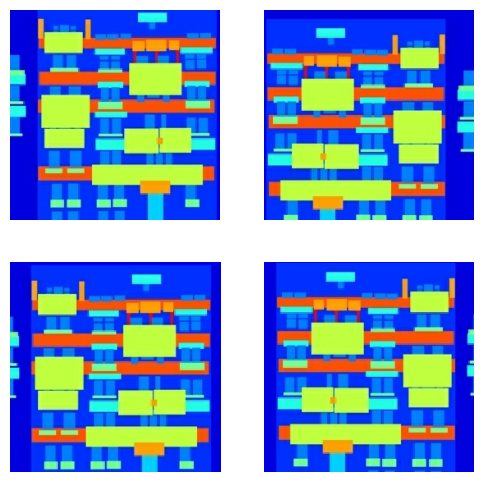

In [15]:
plt.figure(figsize=(6, 6))
for i in range(4):
  rj_inp, rj_re = random_jitter(inp, re)
  plt.subplot(2, 2, i + 1)
  plt.imshow(rj_inp / 255.0)
  plt.axis('off')
plt.show()

読み込みと前処理がうまく機能することを確認したら、トレーニングセットとテストセットを読み込んで前処理するヘルパー関数を 2 つ定義しましょう。

In [16]:
def load_image_train(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = random_jitter(input_image, real_image)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

In [17]:
def load_image_test(image_file):
  input_image, real_image = load(image_file)
  input_image, real_image = resize(input_image, real_image,
                                   IMG_HEIGHT, IMG_WIDTH)
  input_image, real_image = normalize(input_image, real_image)

  return input_image, real_image

## `tf.data` を使用して入力パイプラインを構築する

In [18]:
train_dataset = tf.data.Dataset.list_files(str(PATH / 'train/*.jpg'))
train_dataset = train_dataset.map(load_image_train,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)

In [19]:
try:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'test/*.jpg'))
except tf.errors.InvalidArgumentError:
  test_dataset = tf.data.Dataset.list_files(str(PATH / 'val/*.jpg'))
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(BATCH_SIZE)

## ジェネレータを構築する

pix2pix cGAN のジェネレータは、*調整済みの* [U-Net](https://arxiv.org/abs/1505.04597){:.external}  です。U-Net は、エンコーダ（ダウンサンプラー）とデコーダ（アップサンプラー）で構成されています。（これについては、[画像のセグメンテーション](../images/segmentation.ipynb)チュートリアルと [U-Net プロジェクトのウェブサイト](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/){:.external}  をご覧ください。）

- エンコーダの各ブロック: 畳み込み -&gt; バッチ正規化 -&gt; Leaky ReLU
- デコーダの各ブロック: 転置畳み込み -&gt; バッチ正規化 -&gt; ドロップアウト（最初の 3 つのブロックに適用） -&gt; ReLU
- エンコーダとデコーダ間にはスキップ接続があります（U-Net と同じ）。

ダウンサンプラー（エンコーダ）を定義します。

In [20]:
OUTPUT_CHANNELS = 3

In [21]:
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [22]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(inp, 0))
print (down_result.shape)

(1, 128, 128, 3)


アップサンプラー（デコーダ）を定義します。

In [23]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [24]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


ダウンサンプラーとアップサンプラーを使用してジェネレータを定義します。

In [25]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

ジェネレータモデルアーキテクチャを可視化します。

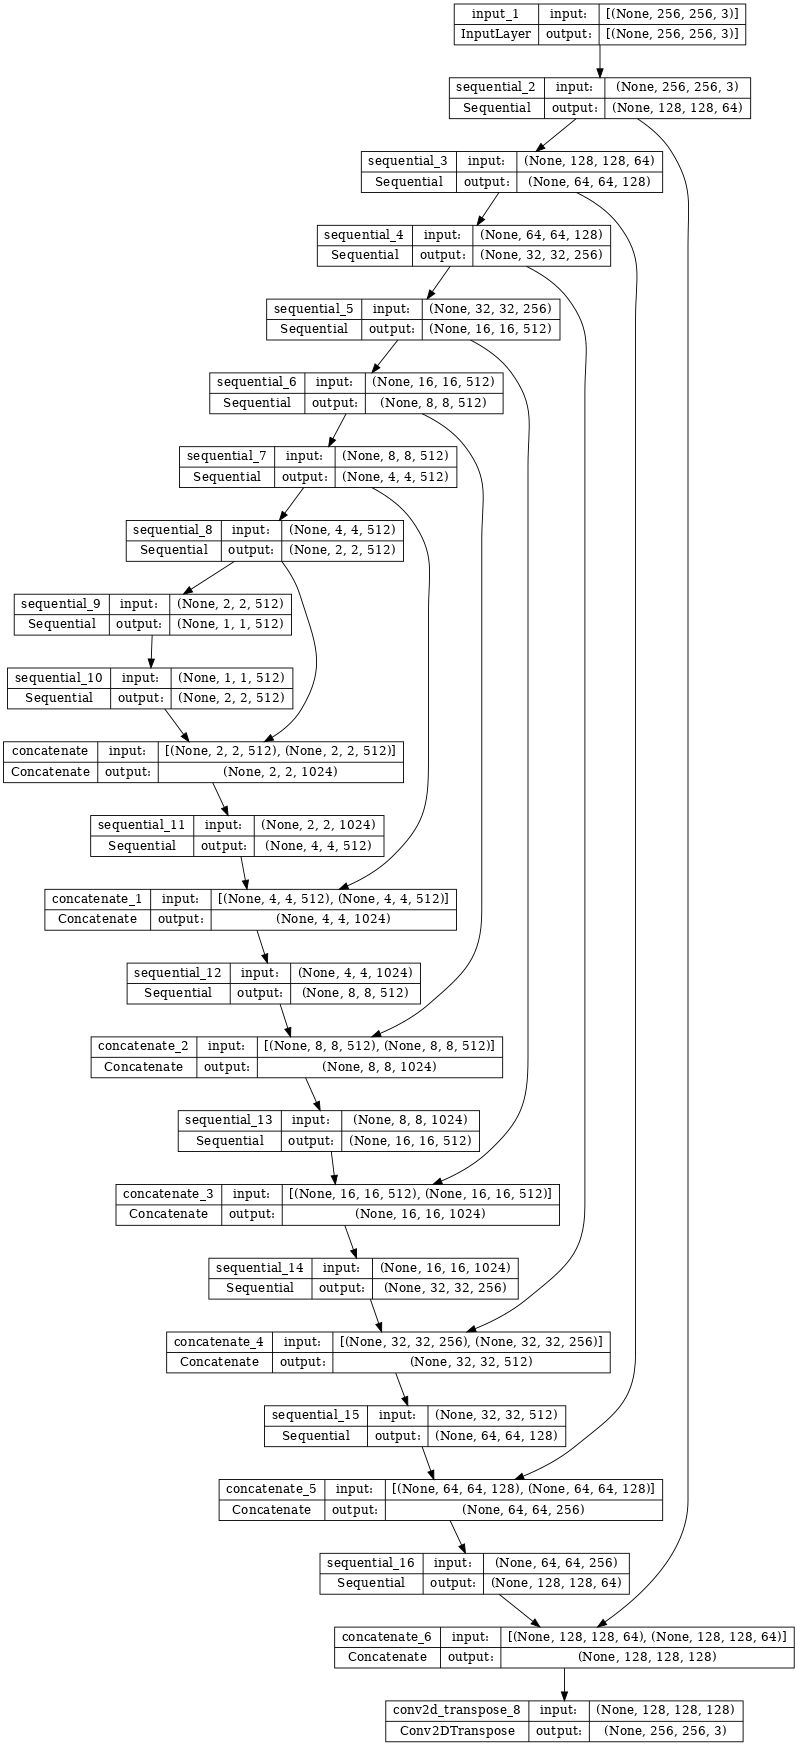

In [26]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

ジェネレータをテストします。

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


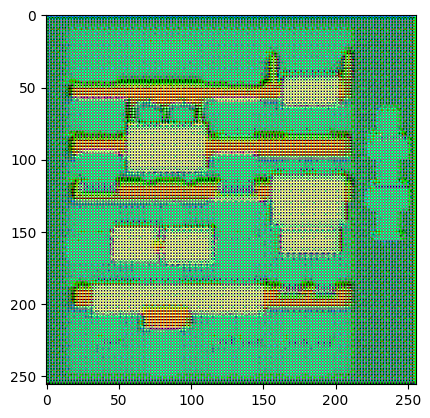

In [27]:
gen_output = generator(inp[tf.newaxis, ...], training=False)
plt.imshow(gen_output[0, ...])

### ジェネレータ損失を定義する

[pix2pix 論文](https://arxiv.org/abs/1611.07004){:.external} によると、GAN はデータに適応する損失を学習するのに対し、cGAN はネットワーク出力とターゲット画像とは異なる可能性のある構造にペナルティを与える構造化損失を学習します。

- ジェネレータ損失は、生成された画像と **1 の配列**のシグモイド交差エントロピー損失です。
- pix2pix 論文には、生成された画像とターゲット画像間の MAE（平均絶対誤差）である L1 損失も言及されています。
- これにより、生成された画像は、構造的にターゲット画像に似るようになります。
- 合計ジェネレータ損失の計算式は、`gan_loss + LAMBDA * l1_loss` で、`LAMBDA = 100` です。この値は論文の執筆者が決定したものです。

In [28]:
LAMBDA = 100

In [29]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [30]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

以下に、ジェネレータのトレーニング手順を示します。

![ジェネレータ更新画像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## ディスクリミネータを構築する

pix2pix cGAN のディスクリミネータは、畳み込み PatchGAN 分類器です。<a>pix2pix 論文</a>{:.external} によると、これは、各画像の<em>パッチ</em>が本物であるか偽物であるかの分類を試みます。

- ディスクリミネータの各ブロック: 畳み込み -&gt; バッチ正規化 -&gt; Leaky ReLU
- 最後のレイヤーの後の出力の形状: `(batch_size, 30, 30, 1)`
- 出力の各 `30 x 30` の画像パッチは入力画像の `70 x 70` の部分を分類します。
- ディスクリミネータは 2 つの入力を受け取ります。
    - 入力画像とターゲット画像。本物として分類する画像です。
    - 入力画像と生成された画像（ジェネレータの出力）。偽物として分類する画像です。
    - `tf.concat([inp, tar], axis=-1)` を使用して、これら 2 つの入力を連結します。

ディスクリミネータを定義しましょう。

In [31]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

ディスクリミネータモデルアーキテクチャを可視化します。

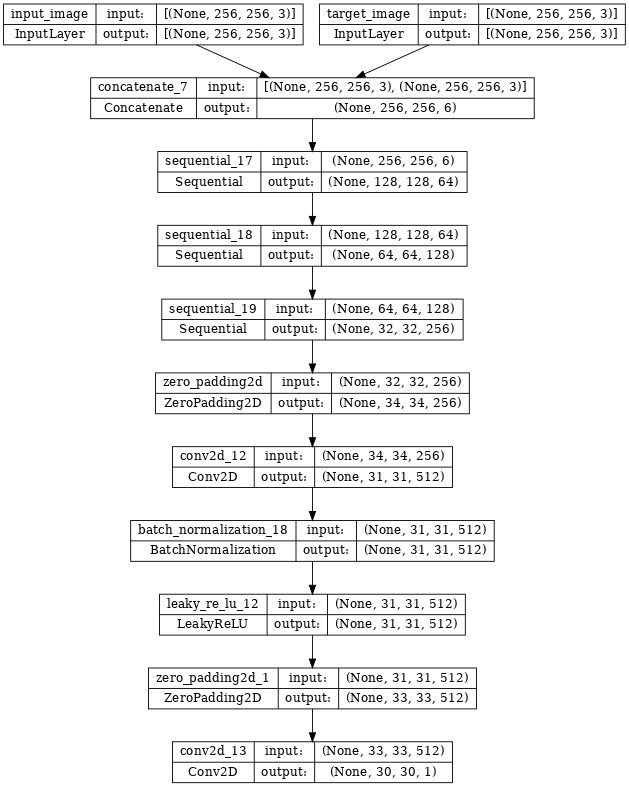

In [32]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

ディスクリミネータをテストします。

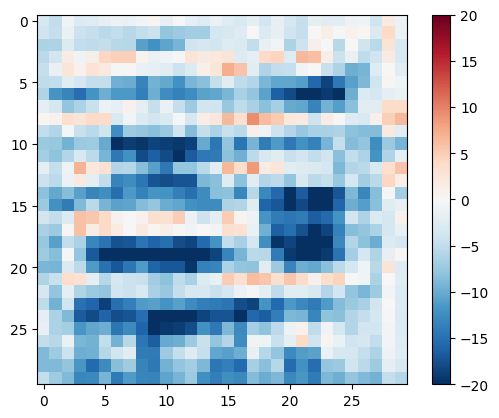

In [33]:
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### ディスクリミネータ損失を定義する

- `discriminator_loss` 関数は、**本物の画像**と**生成された画像**の 2 つの入力を取ります。
- `real_loss` は **本物の画像**と **1 の配列（本物の画像であるため）**のシグモイド交差エントロピー損失です。
- `generated_loss` は、**生成された画像**と **0 の配列（偽物の画像であるため）**のシグモイド交差エントロピー損失です。
- `total_loss` は、`real_loss` と `generated_loss` の和です。

In [34]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

以下に、ディスクリミネータのトレーニング手順を示します。

このアーキテクチャとハイパーパラメータについては、[pix2pix 論文](https://arxiv.org/abs/1611.07004){:.external} をご覧ください。

![ジェネレータ更新画像](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/gen.png?raw=1)


## オプティマイザとチェックポイントセーバーを定義する


In [35]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## 画像を生成する

トレーニング中に画像を描画する関数を記述します。

- テストセットの画像をジェネレータに渡します。
- ジェネレータは入力画像を出力に変換します。
- 最後に、予測をプロットすると、*出来上がり*！

注意: `training=True` は、テストデータセットでモデルを実行中にバッチ統計を行うために、ここに意図的に指定されています。`training=False` を使用した場合、トレーニングデータセットから学習した蓄積された統計が取得されます（ここでは使用したくないデータです）。

In [37]:
def generate_images(model, test_input, tar):
  prediction = model(test_input, training=True)
  plt.figure(figsize=(15, 15))

  display_list = [test_input[0], tar[0], prediction[0]]
  title = ['Input Image', 'Ground Truth', 'Predicted Image']

  for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.title(title[i])
    # Getting the pixel values in the [0, 1] range to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

関数をテストします。

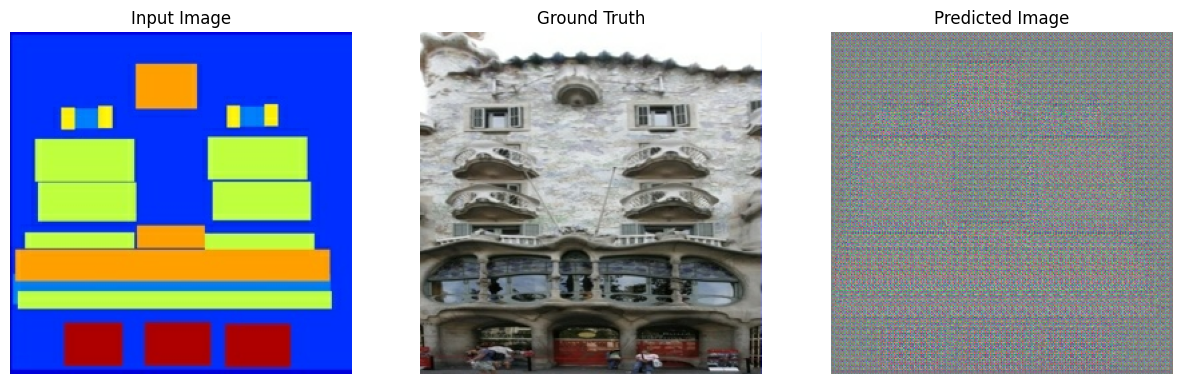

In [38]:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

## トレーニング

- 各サンプルについて、入力は出力を生成します。
- ディスクリミネータは input_image と生成された画像を最初の入力として受け取ります。2 番目の入力は input_image と target_image です。
- 次に、ジェネレータとディスクリミネータの損失を計算します。
- さらに、ジェネレータとディスクリミネータの変数（入力）の両方に関して損失の勾配を計算し、これらをオプティマイザに適用します。
- 最後に、損失を TensorBoard にログします。

In [39]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [40]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

実際のトレーニングループ。このチュートリアルは 2 つ以上のデータセットを実行でき、データセットのサイズは非常に大きく異なるため、トレーニングループはエポックではなくステップで動作するようにセットアップされています。

- ステップの回数をイテレートします。
- 10 ステップごとにドット（`.`）を出力します。
- 1000 ステップごとに、表示を消去し、`generate_images` を実行して進行状況を示します。
- 5000 ステップごとに、チェックポイントを保存します。

In [41]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

このトレーニングループは、TensorBoard に表示してトレーニングの進行状況を監視できるようにログを保存します。

ローカルマシンで作業する場合は、別の TensorBoard プロセスが起動します。ノートブックで作業する場合は、トレーニングを起動する前にビューアーを起動して、TensorBoard で監視します。

TensorFlow ビューアーを起動します（残念ながら、tensorflow.org では表示されません）:

In [ ]:
%load_ext tensorboard
%tensorboard --logdir {log_dir}

[TensorBoard.dev](https://tensorboard.dev/experiment/lZ0C6FONROaUMfjYkVyJqw) で、このノートブックの[前回の実行結果](https://tensorboard.dev/)を閲覧できます。

最後に、トレーニングループを実行します。

Time taken for 1000 steps: 93.30 sec



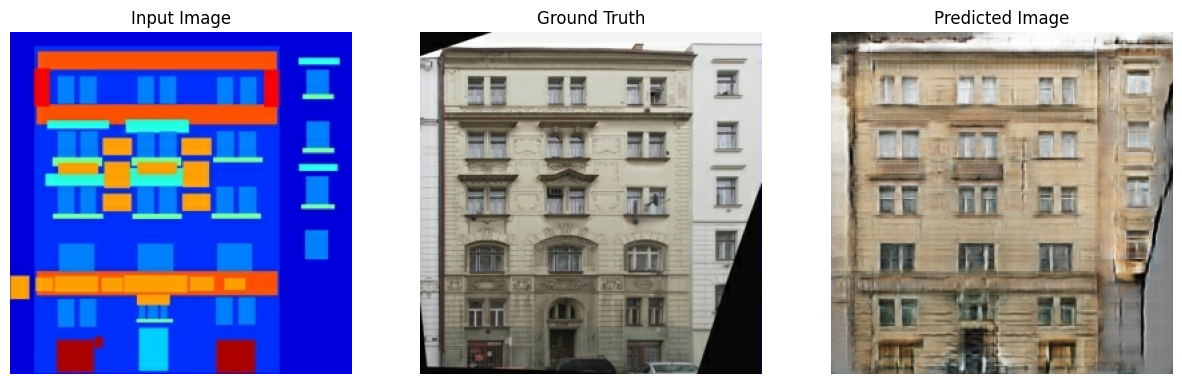

Step: 39k


.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [42]:
fit(train_dataset, test_dataset, steps=40000)

GAN（または pix2pix のような cGAN）をトレーニングする場合、ログの解釈は、単純な分類または回帰モデルよりも明確ではありません。以下の項目に注目してください。

- ジェネレータまたはディスクリミネータのいずれのモデルにも "won" がないことを確認してください。`gen_gan_loss` または `disc_loss`のいずれかが非常に低い場合、そのモデルがもう片方のモデルを上回っていることを示しているため、組み合わされたモデルを正しくトレーニングできていないことになります。
- 値 `log(2) = 0.69` は、これらの損失に適した基準点です。パープレキシティ（予測性能）が 2 であるということは、ディスクリミネータが、平均して 2 つのオプションについて等しく不確実であることを表します。
- `disc_loss` については、値が `0.69` を下回る場合、ディスクリミネータは、本物の画像と生成された画像を組み合わせたセットにおいて、ランダムよりも優れていることを示します。
- `gen_gan_loss` については、値が `0.69` を下回る場合、ジェネレータがディスクリミネータを騙すことにおいて、ランダムよりも優れていることを示します。
- トレーニングが進行するにつれ、`gen_l1_loss`は下降します。

## 最後のチェックポイントを復元してネットワークをテストする

In [43]:
!ls {checkpoint_dir}

checkpoint		    ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index		    ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index		    ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index		    ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [44]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## テストセットを使用して画像を生成する

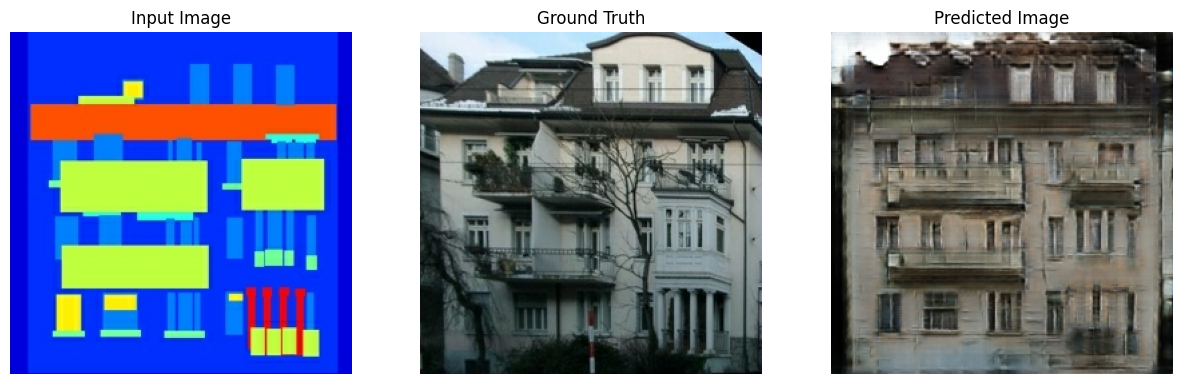

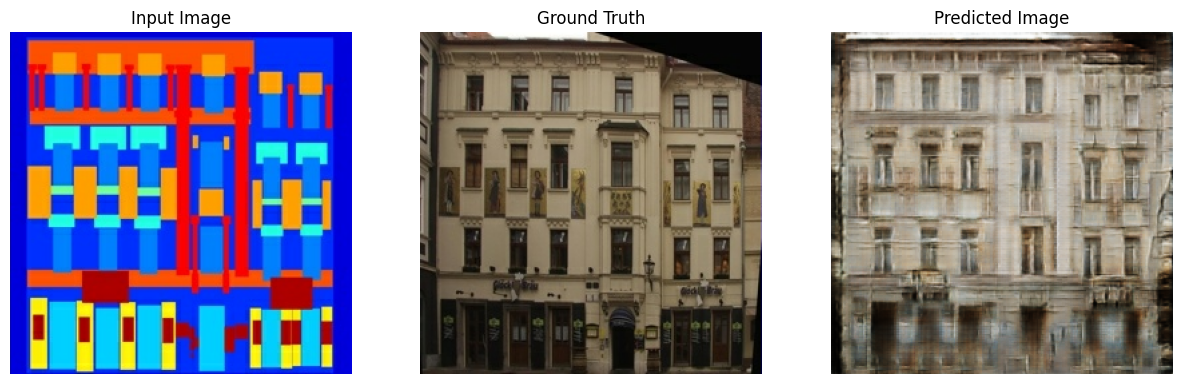

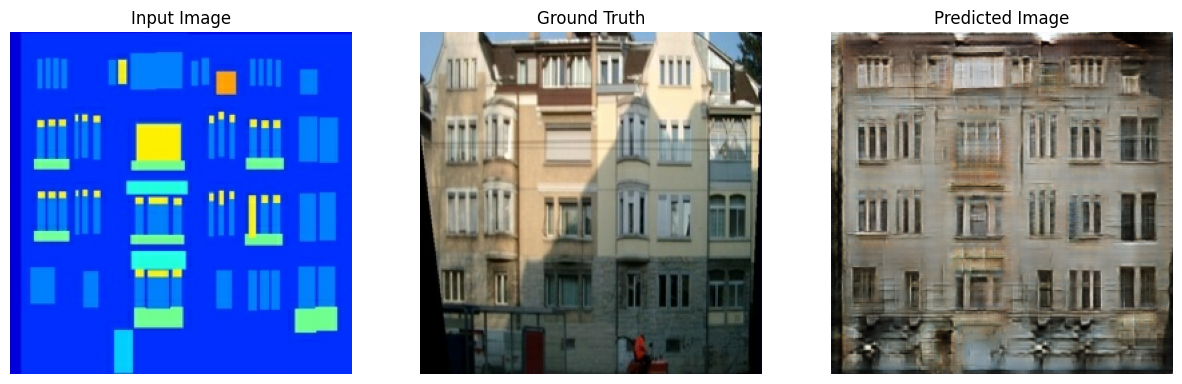

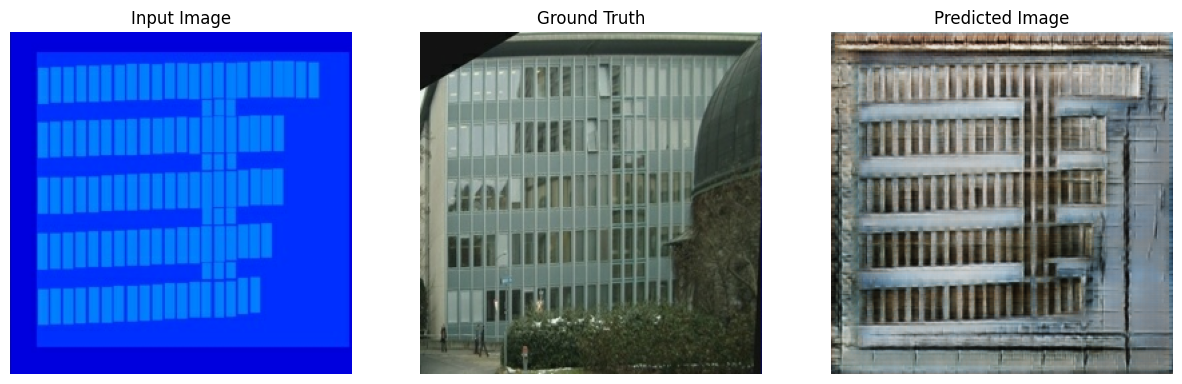

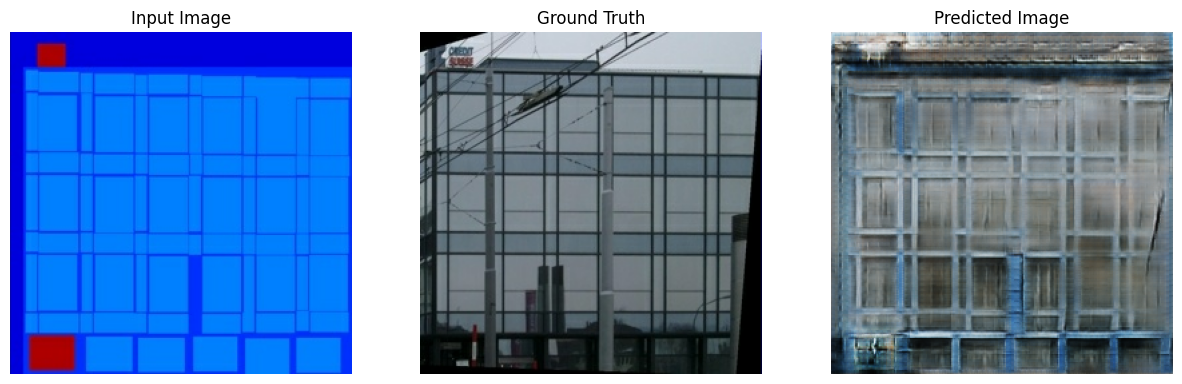

In [45]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)